# EMA Trend + MACD Lab

Top chart: **Close**, **EMA_50**, **EMA_200**, and confirmed trend transitions.
Bottom chart: standard **MACD** (`12, 26, 9`) from close prices.


Trend file: out/trend/APO.csv
Signal file: out/signals/APO.csv
Loaded 782 trend rows and 782 signal rows for APO.
Plot window: 2023-02-14 to 2026-02-13 (target 3 years)
Trend changes in window: 24
MACD crosses in window: 56
Signal events in window: 3


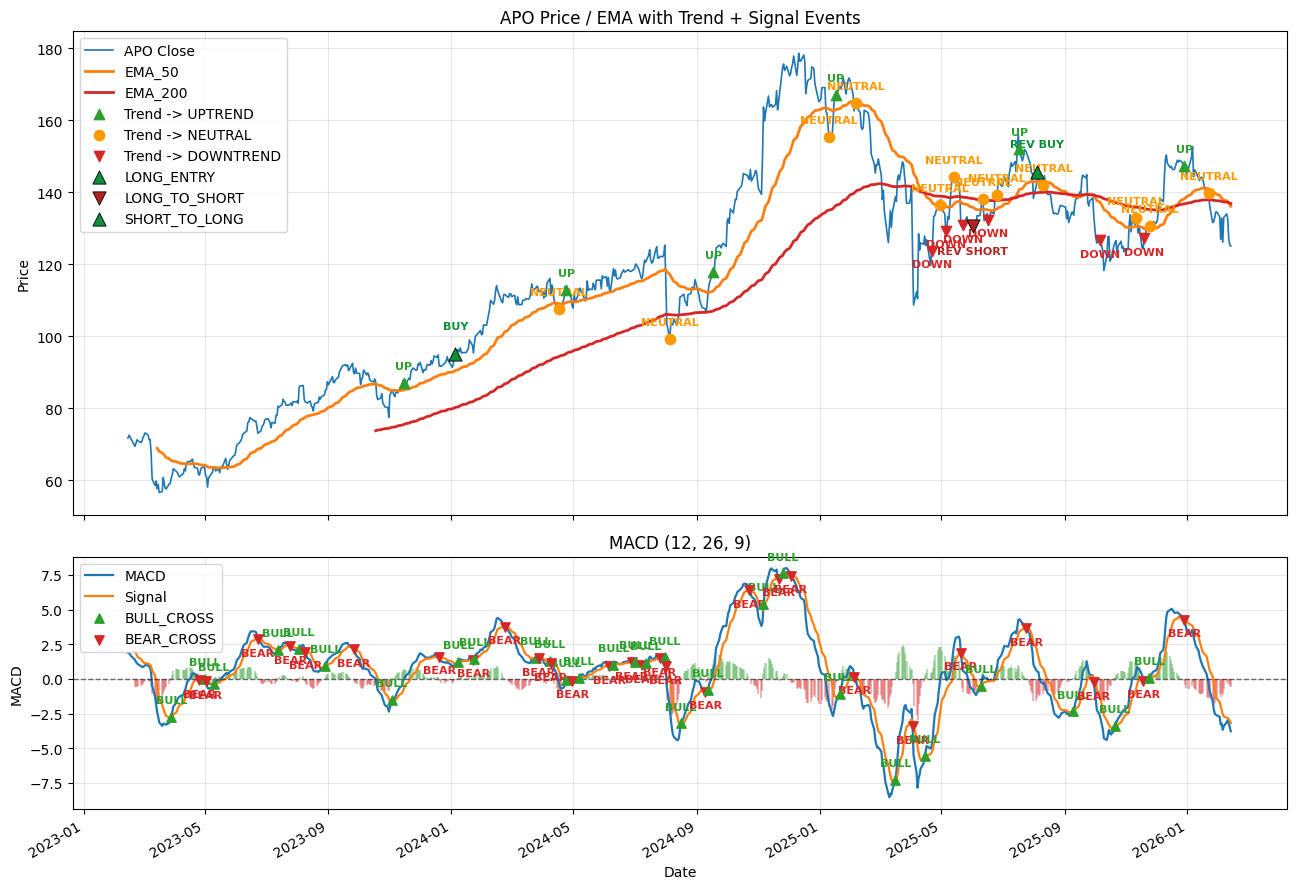

Latest 8 rows:
2026-02-04  Close=132.8000  EMA_50=138.4437  EMA_200=137.4362  Trend=NEUTRAL  Event=  State=LONG  MACD=-3.2242  Signal=-2.2414  Hist=-0.9828
2026-02-05  Close=126.0800  EMA_50=137.9589  EMA_200=137.3232  Trend=NEUTRAL  Event=  State=LONG  MACD=-3.6674  Signal=-2.5266  Hist=-1.1408
2026-02-06  Close=133.0300  EMA_50=137.7656  EMA_200=137.2805  Trend=NEUTRAL  Event=  State=LONG  MACD=-3.4184  Signal=-2.7049  Hist=-0.7134
2026-02-09  Close=133.9500  EMA_50=137.6160  EMA_200=137.2473  Trend=NEUTRAL  Event=  State=LONG  MACD=-3.1110  Signal=-2.7861  Hist=-0.3248
2026-02-10  Close=132.4300  EMA_50=137.4126  EMA_200=137.1994  Trend=NEUTRAL  Event=  State=LONG  MACD=-2.9559  Signal=-2.8201  Hist=-0.1358
2026-02-11  Close=126.9500  EMA_50=137.0023  EMA_200=137.0974  Trend=NEUTRAL  Event=  State=LONG  MACD=-3.2379  Signal=-2.9037  Hist=-0.3343
2026-02-12  Close=125.3700  EMA_50=136.5461  EMA_200=136.9807  Trend=NEUTRAL  Event=  State=LONG  MACD=-3.5480  Signal=-3.0325  Hist=-0.515

In [1]:
from pathlib import Path
import csv
from datetime import date, timedelta
import matplotlib.pyplot as plt

SYMBOL = "APO"
YEARS_TO_PLOT = 3
MACD_FAST = 12
MACD_SLOW = 26
MACD_SIGNAL = 9


def resolve_data_dir(subdir: str) -> Path:
    candidates = [Path.cwd(), Path.cwd().parent]
    for candidate in candidates:
        target = candidate / "out" / subdir
        if target.exists():
            return target
    raise FileNotFoundError(
        f"Could not find out/{subdir}. Run Jupyter from repo root or notebooks/, and regenerate outputs first."
    )


def parse_float(value: str | None) -> float | None:
    raw = (value or "").strip()
    if not raw:
        return None
    return float(raw)


def compute_ema(values: list[float], period: int) -> list[float | None]:
    output: list[float | None] = [None] * len(values)
    if period <= 0 or len(values) < period:
        return output

    smoothing = 2.0 / (period + 1.0)
    seed = sum(values[:period]) / period
    output[period - 1] = seed

    prev = seed
    for idx in range(period, len(values)):
        current = (values[idx] - prev) * smoothing + prev
        output[idx] = current
        prev = current

    return output


def load_rows(csv_path: Path) -> list[dict[str, str]]:
    with csv_path.open("r", encoding="utf-8", newline="") as handle:
        reader = csv.DictReader(handle)
        rows = list(reader)
    if not rows:
        raise ValueError(f"No rows found in {csv_path}")
    return rows


trend_dir = resolve_data_dir("trend")
signal_dir = resolve_data_dir("signals")
trend_csv = trend_dir / f"{SYMBOL}.csv"
signal_csv = signal_dir / f"{SYMBOL}.csv"

if not trend_csv.exists():
    raise FileNotFoundError(
        f"Missing file: {trend_csv}. Run: python3 trend_analyzer.py --buffer-pct 0.5 --confirm-bars 3"
    )

if not signal_csv.exists():
    raise FileNotFoundError(
        f"Missing file: {signal_csv}. Run: python3 signal_engine_v2.py"
    )

rows = load_rows(trend_csv)
signal_rows = load_rows(signal_csv)
rows.sort(key=lambda row: row["Date"])
signal_rows.sort(key=lambda row: row["Date"])

signal_event_by_date = {
    row["Date"]: (row.get("SignalEvent") or "").strip() for row in signal_rows
}
signal_state_by_date = {
    row["Date"]: (row.get("SignalState") or "").strip() for row in signal_rows
}


dates = [date.fromisoformat(row["Date"]) for row in rows]
close_prices = [float(row["Close"]) for row in rows]
ema50 = [parse_float(row.get("EMA_50")) for row in rows]
ema200 = [parse_float(row.get("EMA_200")) for row in rows]
trends = [(row.get("Trend") or "NEUTRAL").strip() for row in rows]
signal_events = [signal_event_by_date.get(row["Date"], "") for row in rows]


macd_fast = compute_ema(close_prices, MACD_FAST)
macd_slow = compute_ema(close_prices, MACD_SLOW)

macd_line: list[float | None] = []
for fast_val, slow_val in zip(macd_fast, macd_slow, strict=True):
    if fast_val is None or slow_val is None:
        macd_line.append(None)
    else:
        macd_line.append(fast_val - slow_val)

valid_macd_idx = [idx for idx, value in enumerate(macd_line) if value is not None]
valid_macd_values = [macd_line[idx] for idx in valid_macd_idx]
signal_compact = compute_ema([float(v) for v in valid_macd_values], MACD_SIGNAL)
macd_signal: list[float | None] = [None] * len(macd_line)
for compact_idx, full_idx in enumerate(valid_macd_idx):
    macd_signal[full_idx] = signal_compact[compact_idx]

macd_hist: list[float | None] = []
for line_val, signal_val in zip(macd_line, macd_signal, strict=True):
    if line_val is None or signal_val is None:
        macd_hist.append(None)
    else:
        macd_hist.append(line_val - signal_val)


macd_cross_events: list[tuple[int, str]] = []
for idx in range(1, len(macd_line)):
    prev_line = macd_line[idx - 1]
    prev_signal = macd_signal[idx - 1]
    curr_line = macd_line[idx]
    curr_signal = macd_signal[idx]
    if prev_line is None or prev_signal is None or curr_line is None or curr_signal is None:
        continue
    if prev_line <= prev_signal and curr_line > curr_signal:
        macd_cross_events.append((idx, "BULL_CROSS"))
    elif prev_line >= prev_signal and curr_line < curr_signal:
        macd_cross_events.append((idx, "BEAR_CROSS"))


change_events: list[tuple[int, str]] = []
for idx in range(1, len(trends)):
    if trends[idx] != trends[idx - 1]:
        change_events.append((idx, trends[idx]))

signal_event_points = [
    (idx, event)
    for idx, event in enumerate(signal_events)
    if event
]

window_start_date = dates[-1] - timedelta(days=365 * YEARS_TO_PLOT)
start_idx = next((idx for idx, row_date in enumerate(dates) if row_date >= window_start_date), 0)

plot_dates = dates[start_idx:]
plot_close = close_prices[start_idx:]
plot_ema50 = ema50[start_idx:]
plot_ema200 = ema200[start_idx:]
plot_macd_line = macd_line[start_idx:]
plot_macd_signal = macd_signal[start_idx:]
plot_macd_hist = macd_hist[start_idx:]
window_changes = [(idx, trend) for idx, trend in change_events if idx >= start_idx]
window_macd_crosses = [(idx, cross_type) for idx, cross_type in macd_cross_events if idx >= start_idx]
window_signal_events = [(idx, event) for idx, event in signal_event_points if idx >= start_idx]
display_root = trend_dir.parent.parent

print(f"Trend file: {trend_csv.relative_to(display_root).as_posix()}")
print(f"Signal file: {signal_csv.relative_to(display_root).as_posix()}")
print(f"Loaded {len(rows)} trend rows and {len(signal_rows)} signal rows for {SYMBOL}.")
print(f"Plot window: {plot_dates[0]} to {plot_dates[-1]} (target {YEARS_TO_PLOT} years)")
print(f"Trend changes in window: {len(window_changes)}")
print(f"MACD crosses in window: {len(window_macd_crosses)}")
print(f"Signal events in window: {len(window_signal_events)}")

fig, (ax_price, ax_macd) = plt.subplots(2, 1, figsize=(13, 9), sharex=True, gridspec_kw={"height_ratios": [2.3, 1.2]})

ax_price.plot(plot_dates, plot_close, label=f"{SYMBOL} Close", color="#1f77b4", linewidth=1.2)
ax_price.plot(plot_dates, plot_ema50, label="EMA_50", color="#ff7f0e", linewidth=2.0)
ax_price.plot(plot_dates, plot_ema200, label="EMA_200", color="#d62728", linewidth=2.0)

trend_style = {
    "UPTREND": {"color": "#2ca02c", "marker": "^", "text": "UP", "offset": 10},
    "DOWNTREND": {"color": "#d62728", "marker": "v", "text": "DOWN", "offset": -12},
    "NEUTRAL": {"color": "#ff9900", "marker": "o", "text": "NEUTRAL", "offset": 10},
}
legend_seen: set[str] = set()

for idx, trend in window_changes:
    style = trend_style.get(trend)
    if style is None:
        continue

    row_date = dates[idx]
    y_value = close_prices[idx]
    marker_label = f"Trend -> {trend}" if trend not in legend_seen else "_nolegend_"
    legend_seen.add(trend)

    ax_price.scatter([row_date], [y_value], s=55, marker=style["marker"], color=style["color"], label=marker_label, zorder=6)
    ax_price.annotate(style["text"], (row_date, y_value), textcoords="offset points", xytext=(0, style["offset"]), ha="center", fontsize=8, color=style["color"], fontweight="bold")

signal_style = {
    "LONG_ENTRY": {"color": "#0b8f3a", "marker": "^", "text": "BUY", "offset": 18},
    "SHORT_TO_LONG": {"color": "#0b8f3a", "marker": "^", "text": "REV BUY", "offset": 18},
    "SHORT_ENTRY": {"color": "#b22222", "marker": "v", "text": "SHORT", "offset": -20},
    "LONG_TO_SHORT": {"color": "#b22222", "marker": "v", "text": "REV SHORT", "offset": -20},
}
signal_legend_seen: set[str] = set()

for idx, event_name in window_signal_events:
    style = signal_style.get(event_name)
    if style is None:
        continue

    row_date = dates[idx]
    y_value = close_prices[idx]
    marker_label = event_name if event_name not in signal_legend_seen else "_nolegend_"
    signal_legend_seen.add(event_name)

    ax_price.scatter(
        [row_date],
        [y_value],
        s=90,
        marker=style["marker"],
        color=style["color"],
        edgecolors="#111111",
        linewidths=0.7,
        label=marker_label,
        zorder=8,
    )
    ax_price.annotate(
        style["text"],
        (row_date, y_value),
        textcoords="offset points",
        xytext=(0, style["offset"]),
        ha="center",
        fontsize=8,
        color=style["color"],
        fontweight="bold",
    )

ax_price.set_title(f"{SYMBOL} Price / EMA with Trend + Signal Events")
ax_price.set_ylabel("Price")
ax_price.grid(alpha=0.3)
ax_price.legend(loc="best")

for plot_date, hist_value in zip(plot_dates, plot_macd_hist, strict=True):
    if hist_value is None:
        continue
    color = "#2ca02c" if hist_value >= 0 else "#d62728"
    ax_macd.bar(plot_date, hist_value, color=color, alpha=0.35, width=2)

ax_macd.plot(plot_dates, plot_macd_line, label="MACD", color="#1f77b4", linewidth=1.6)
ax_macd.plot(plot_dates, plot_macd_signal, label="Signal", color="#ff7f0e", linewidth=1.6)

cross_style = {
    "BULL_CROSS": {"color": "#2ca02c", "marker": "^", "text": "BULL", "offset": 10},
    "BEAR_CROSS": {"color": "#d62728", "marker": "v", "text": "BEAR", "offset": -12},
}
cross_legend_seen: set[str] = set()

for idx, cross_type in window_macd_crosses:
    style = cross_style.get(cross_type)
    if style is None:
        continue
    y_value = macd_line[idx]
    if y_value is None:
        continue
    row_date = dates[idx]
    legend_label = cross_type if cross_type not in cross_legend_seen else "_nolegend_"
    cross_legend_seen.add(cross_type)
    ax_macd.scatter([row_date], [y_value], s=45, marker=style["marker"], color=style["color"], label=legend_label, zorder=6)
    ax_macd.annotate(style["text"], (row_date, y_value), textcoords="offset points", xytext=(0, style["offset"]), ha="center", fontsize=8, color=style["color"], fontweight="bold")

ax_macd.axhline(0.0, color="#111111", linewidth=1.0, alpha=0.6, linestyle="--")
ax_macd.set_title(f"MACD ({MACD_FAST}, {MACD_SLOW}, {MACD_SIGNAL})")
ax_macd.set_xlabel("Date")
ax_macd.set_ylabel("MACD")
ax_macd.grid(alpha=0.3)
ax_macd.legend(loc="best")

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

print("Latest 8 rows:")
for idx in range(max(0, len(rows) - 8), len(rows)):
    ema50_text = "" if ema50[idx] is None else f"{ema50[idx]:.4f}"
    ema200_text = "" if ema200[idx] is None else f"{ema200[idx]:.4f}"
    macd_text = "" if macd_line[idx] is None else f"{macd_line[idx]:.4f}"
    signal_text = "" if macd_signal[idx] is None else f"{macd_signal[idx]:.4f}"
    hist_text = "" if macd_hist[idx] is None else f"{macd_hist[idx]:.4f}"
    event_text = signal_events[idx]
    state_text = signal_state_by_date.get(rows[idx]["Date"], "")
    print(
        f"{dates[idx]}  Close={close_prices[idx]:.4f}  EMA_50={ema50_text}  EMA_200={ema200_text}  "
        f"Trend={trends[idx]}  Event={event_text}  State={state_text}  MACD={macd_text}  Signal={signal_text}  Hist={hist_text}"
    )

